In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import EvaluatePredictions
from PREDICT.Metrics import Accuracy, AUROC, AUPRC, F1Score, Precision, Recall, Sensitivity, Specificity, OE

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Basic Example - Evaluating an existing prediction model

In this simple scenario, we are evaluating a pre-existing model which makes binary predictions. We are going to track a variety of metrics over a two year period.

Our fake data and model is going to vary in performance over time, with a maximum performance of 90% accuracy.

We are not doing any recalibration, model updating etc., simply observing the performance of this pre-existing model over time.

# Create some synthetic data

To demonstrate this, we'll create some synthetic data across 104 weeks with accuracy declining over time.

Start with accuracy = 90% and dropping linearly to 50% by the end of the year.

For each day, create 100 fake datapoints with that expected level of accuracy classified correctly.

In [2]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list()
}
np.random.seed(42)
numweeks = 104
startDate = pd.to_datetime('01-01-2024', dayfirst=True)
endDate = pd.to_datetime('31-12-2024', dayfirst=True)
numdays = (endDate - startDate).days
accuracy_start = 0.9
accuracy_end = 0.5
accuracy_drop = (accuracy_start-accuracy_end)/numdays

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)
    curaccuracy = accuracy_start - accuracy_drop*i
    # Generate fake outcomes
    curoutcomes = np.random.choice([0, 1], size=100, p=[0.7, 0.3])
    # Generate fake outcomes to match current accuracy level
    correct = np.random.choice([0, 1], size=100, p=[1-curaccuracy, curaccuracy])
    ix = list(np.where(correct==0)[0])
    curpredictions = curoutcomes.copy()
    curpredictions[ix] = 1-curpredictions[ix]
    # Append to dictionary
    mydict['date'].extend([curday]*100)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)

df = pd.DataFrame(mydict)

In [3]:
df.head()

,date,outcome,prediction
0,2024-01-01,0,1
1,2024-01-01,1,1
2,2024-01-01,1,1
3,2024-01-01,0,0
4,2024-01-01,0,0


# Temporal drift of accuracy over time
Now we will setup a PREDICT framework to evaluate the drift in accuracy over time.

Since we are evaluating model predictions that are already within the dataframe, we can use EvaluatePredictions as shown below.

We want to test the accuracy from the start of the dataset until the end, in weekly timesteps.

In [4]:
model = EvaluatePredictions(colName='prediction')
mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='week')
mytest.addLogHook(Accuracy(model))

# Track metrics over time
We now add a number of logHooks for each metric that we want to track.

In [5]:
mytest.addLogHook(AUROC(model))
mytest.addLogHook(AUPRC(model))
mytest.addLogHook(F1Score(model))
mytest.addLogHook(Precision(model))
mytest.addLogHook(Recall(model))
mytest.addLogHook(Sensitivity(model))
mytest.addLogHook(Specificity(model))
mytest.addLogHook(OE(model))

# Run the temporal drift detection
mytest.run()

In [6]:
# Get the logged accuracy scores and print them out
log = mytest.getLog()
log['Accuracy']

{Timestamp('2024-01-08 00:00:00'): np.float64(0.9042857142857142),
 Timestamp('2024-01-15 00:00:00'): np.float64(0.8757142857142857),
 Timestamp('2024-01-22 00:00:00'): np.float64(0.8771428571428571),
 Timestamp('2024-01-29 00:00:00'): np.float64(0.87),
 Timestamp('2024-02-05 00:00:00'): np.float64(0.8571428571428571),
 Timestamp('2024-02-12 00:00:00'): np.float64(0.8457142857142858),
 Timestamp('2024-02-19 00:00:00'): np.float64(0.87),
 Timestamp('2024-02-26 00:00:00'): np.float64(0.8614285714285714),
 Timestamp('2024-03-04 00:00:00'): np.float64(0.8214285714285714),
 Timestamp('2024-03-11 00:00:00'): np.float64(0.8328571428571429),
 Timestamp('2024-03-18 00:00:00'): np.float64(0.8114285714285714),
 Timestamp('2024-03-25 00:00:00'): np.float64(0.8214285714285714),
 Timestamp('2024-04-01 00:00:00'): np.float64(0.8171428571428572),
 Timestamp('2024-04-08 00:00:00'): np.float64(0.8185714285714286),
 Timestamp('2024-04-15 00:00:00'): np.float64(0.8185714285714286),
 Timestamp('2024-04-22 

After this is done, we can loop through the log and print the various metrics over time as follows.

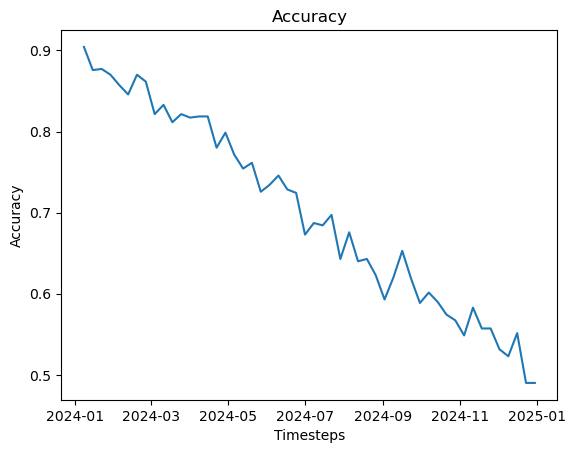

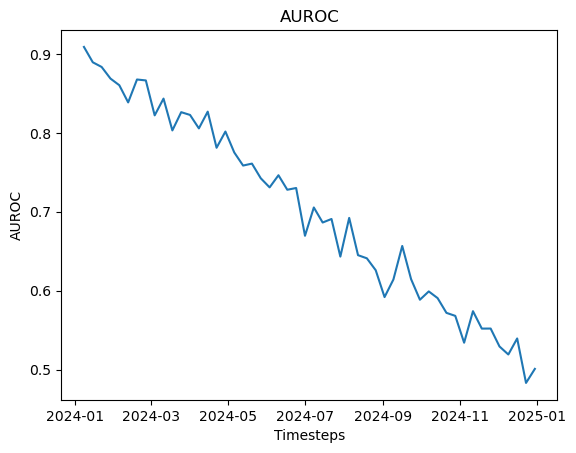

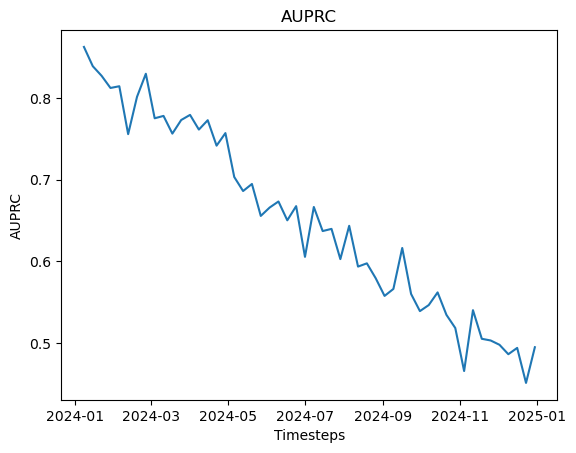

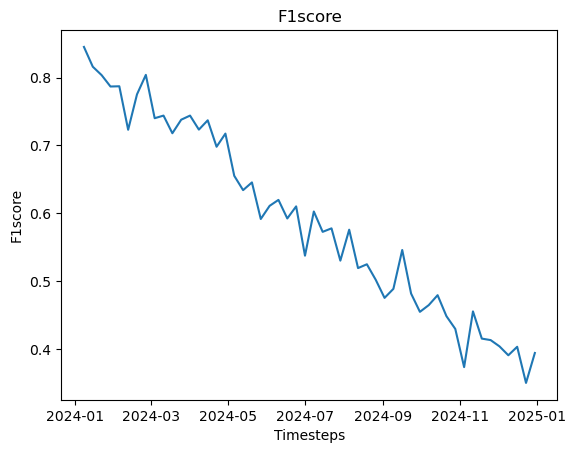

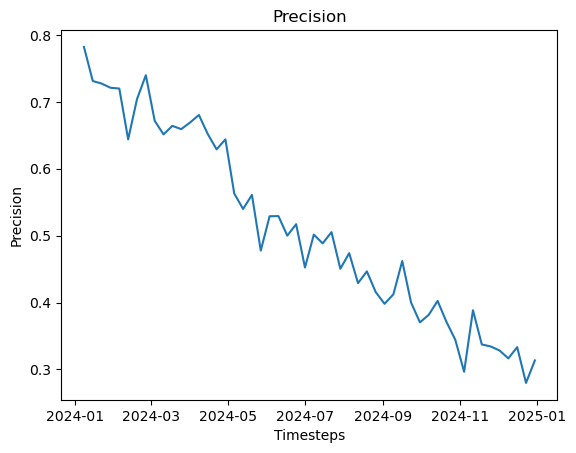

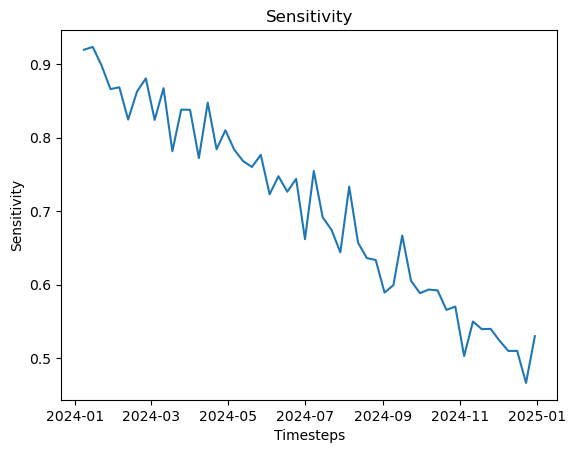

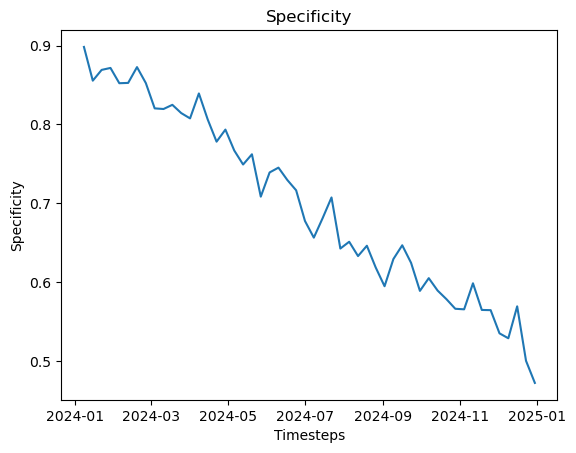

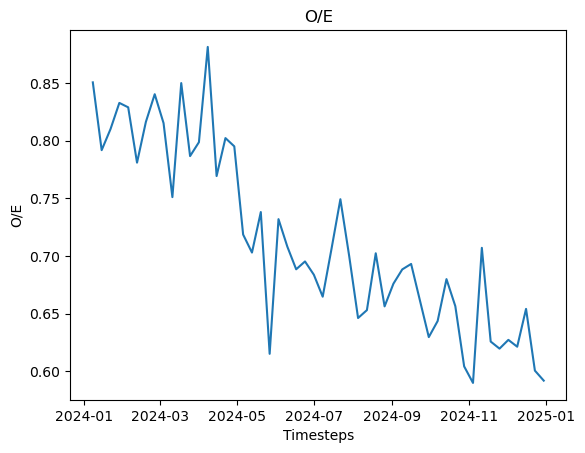

In [7]:
for key in log.keys():
    curlog = log[key]
    plt.figure()
    plt.plot(curlog.keys(), curlog.values())
    plt.title(key)
    plt.xlabel('Timesteps')
    plt.ylabel(key)
    